In [232]:
import pandas as pd
import numpy as np
import tqdm

In [233]:
! ls 

discrete_optimisation.ipynb        marketing_campaign_estimations.csv
generate_data.ipynb                net_earnings_eu.tsv
iso_codes.txt                      population.tsv


In [234]:
df = pd.read_csv('marketing_campaign_estimations.csv', sep = '\t')

In [235]:
df.head()

,country,channel,users,cs_contacts,marketing_spending,revenue
0,Austria,social networks,2483,113,1348442.81,5947157.45
1,Belgium,social networks,3318,173,2800790.16,9100510.86
2,Bulgaria,social networks,2168,115,130578.64,626140.08
3,Switzerland,social networks,2681,180,1781765.79,10498340.23
4,Cyprus,social networks,263,0,73398.04,274979.65


In [236]:
df['segment'] = df.country + ' - ' + df.channel

In [237]:
len(df.segment)

62

In [238]:
df.cs_contacts.sum()

9489

In [239]:
df.head()

,country,channel,users,cs_contacts,marketing_spending,revenue,segment
0,Austria,social networks,2483,113,1348442.81,5947157.45,Austria - social networks
1,Belgium,social networks,3318,173,2800790.16,9100510.86,Belgium - social networks
2,Bulgaria,social networks,2168,115,130578.64,626140.08,Bulgaria - social networks
3,Switzerland,social networks,2681,180,1781765.79,10498340.23,Switzerland - social networks
4,Cyprus,social networks,263,0,73398.04,274979.65,Cyprus - social networks


In [240]:
df.channel.value_counts()

channel
social networks    31
influencers        31
Name: count, dtype: int64

In [241]:
total_stats_df = df.groupby('channel', as_index = False).agg(
    {'users': 'sum', 'marketing_spending': 'sum', 'revenue': 'sum', 'cs_contacts': 'sum'}
)

In [244]:
total_stats_df['marketing_spending'] = total_stats_df.marketing_spending/10**6
total_stats_df['revenue'] = total_stats_df.revenue/10**6

total_stats_df

,channel,users,marketing_spending,revenue,cs_contacts
0,influencers,35735,0.000018,0.000058,1725
1,social networks,168030,0.000046,0.000148,7764


### Brute force 

In [282]:
2**62/10**18

4.611686018427388

In [245]:
import itertools

combinations = []
segments = list(df.segment.values)[:15]
print('number of segments: ', len(segments))
for num_items in range(len(segments) + 1):
    combinations.extend(
        itertools.combinations(segments, num_items)
    )

print('number of combinations: ', len(combinations))

number of segments:  15
number of combinations:  32768


In [246]:
tmp = []

for selected in tqdm.tqdm(combinations):
    tmp_df = df[df.segment.isin(selected)]
    tmp.append(
        {
        'selected_segments': ', '.join(selected),
        'users': tmp_df.users.sum(),
        'cs_contacts': tmp_df.cs_contacts.sum(),
        'marketing_spending': tmp_df.marketing_spending.sum(),
        'revenue': tmp_df.revenue.sum()
        }
    )

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32768/32768 [00:04<00:00, 6933.57it/s]


In [247]:
2**62 / 7000 / 3600 / 24 / 365

20890800.619824003

In [248]:
res_df = pd.DataFrame(tmp)

In [249]:
res_df.sort_values('revenue', ascending = False)

,selected_segments,users,cs_contacts,marketing_spending,revenue
32767,"Austria - social networks, Belgium - social ne...",88318,4063,27467731.24,89218064.93
32762,"Austria - social networks, Belgium - social ne...",88055,4063,27394333.20,88943085.28
32758,"Austria - social networks, Belgium - social ne...",87921,4054,27354050.29,88919771.04
32698,"Austria - social networks, Belgium - social ne...",87658,4054,27280652.25,88644791.39
32764,"Austria - social networks, Belgium - social ne...",86150,3948,27337152.60,88591924.85
...,...,...,...,...,...
3,Bulgaria - social networks,2168,115,130578.64,626140.08
69,"Cyprus - social networks, Estonia - social net...",660,9,187078.99,573273.54
9,Estonia - social networks,397,9,113680.95,298293.89
5,Cyprus - social networks,263,0,73398.04,274979.65


### Naive approach

In [250]:
df['revenue_per_spend'] = df.revenue / df.marketing_spending 
df = df.sort_values('revenue_per_spend', ascending = False)
df['spend_cumulative'] = df.marketing_spending.cumsum()
df[df.spend_cumulative <= 30000000].revenue.sum()/1000000

107.91584679

In [307]:
df[df.spend_cumulative <= 30000000].shape[0]

48

### Merging segments

In [295]:
df['share_of_revenue'] = df.revenue/df.revenue.sum() * 100

In [296]:
# ! pip install matplotlib

In [297]:
from matplotlib import pyplot

<Axes: >

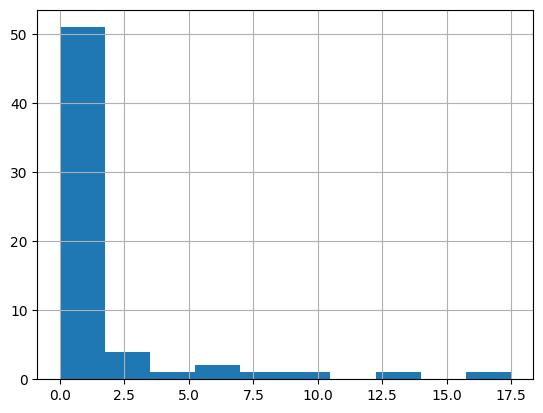

In [298]:
df.share_of_cs_contacts.hist(bins = 10)

In [299]:
df.sort_values('share_of_revenue').head(10)

,country,channel,users,cs_contacts,marketing_spending,revenue,segment,revenue_per_spend,spend_cumulative,share_of_cs_contacts,segment_group,contacts_per_user,selected,share_of_spend,share_of_revenue
33,Bulgaria,influencers,75,3,11178.75,38001.00,Bulgaria - influencers,3.399396,16989049.50,0.031616,good,0.040000,1.0,0.017509,0.018494
49,Lithuania,influencers,88,3,17395.84,52408.40,Lithuania - influencers,3.012697,29234846.71,0.031616,good,0.034091,0.0,0.027247,0.025506
57,Romania,influencers,89,4,17801.78,72497.62,Romania - influencers,4.072493,5254066.33,0.042154,Romania - influencers,0.044944,1.0,0.027883,0.035283
45,Hungary,influencers,106,8,20981.64,74415.18,Hungary - influencers,3.546681,9422126.91,0.084308,Hungary - influencers,0.075472,1.0,0.032863,0.036216
21,Malta,social networks,144,5,19540.80,74854.08,Malta - social networks,3.830656,6180321.50,0.052693,good,0.034722,1.0,0.030606,0.036430
60,Slovakia,influencers,109,8,40242.80,123362.93,Slovakia - influencers,3.065466,27174990.14,0.084308,Slovakia - influencers,0.073394,1.0,0.063031,0.060038
39,Estonia,influencers,103,5,38026.57,131537.18,Estonia - influencers,3.459086,10264324.63,0.052693,Estonia - influencers,0.048544,1.0,0.059560,0.064016
52,Malta,influencers,123,8,46033.98,152977.56,Malta - influencers,3.323144,17035083.48,0.084308,Malta - influencers,0.065041,1.0,0.072102,0.074450
59,Slovenia,influencers,100,5,44757.00,169291.00,Slovenia - influencers,3.782447,6651751.81,0.052693,Slovenia - influencers,0.050000,1.0,0.070102,0.082390
16,Iceland,social networks,109,1,64267.49,202152.49,Iceland - social networks,3.145486,20698459.62,0.010539,good,0.009174,1.0,0.100661,0.098383


In [302]:
df['segment_group'] = list(map(
    lambda x, y: x if y >= 0.1 else 'other',
    df.segment,
    df.share_of_revenue
))

In [304]:
df[df.segment_group == 'other'].share_of_revenue.sum()

0.5312050617653221

In [305]:
df[df.segment_group == 'other'].shape

(10, 15)

In [303]:
df.segment_group.nunique()

53

In [306]:
2**52 / 7000 / 3600 / 24 / 365

20401.17248029688

In [259]:
df.cs_contacts.sum()/df.users.sum()

0.0465683507962604

In [260]:
df['contacts_per_user'] = df.cs_contacts/df.users

In [261]:
df[df.contacts_per_user <= 0.045].shape

(23, 12)

In [262]:
df['segment_group'] = list(map(
    lambda x, y: x if y > 0.042 else 'good',
    df.segment,
    df.contacts_per_user
))

In [263]:
df.segment_group.nunique()

43

In [264]:
2**41 / 7000 / 3600 / 24 / 365

9.96151000014496

### Linear optimisations

In [265]:
! pip install pulp


[notice] A new release of pip is available: 23.3.1 -> 24.3.1
[notice] To update, run: pip install --upgrade pip


In [266]:
df.head()

,country,channel,users,cs_contacts,marketing_spending,revenue,segment,revenue_per_spend,spend_cumulative,share_of_cs_contacts,segment_group,contacts_per_user
27,Sweden,social networks,3088,108,1075828.32,6952261.44,Sweden - social networks,6.462241,1075828.32,1.138160,good,0.034974
3,Switzerland,social networks,2681,180,1781765.79,10498340.23,Switzerland - social networks,5.892099,2857594.11,1.896933,Switzerland - social networks,0.067139
18,Lithuania,social networks,730,46,106492.40,528038.20,Lithuania - social networks,4.958459,2964086.51,0.484772,Lithuania - social networks,0.063014
2,Bulgaria,social networks,2168,115,130578.64,626140.08,Bulgaria - social networks,4.795119,3094665.15,1.211930,Bulgaria - social networks,0.053044
29,Slovakia,social networks,1702,46,274056.04,1309586.88,Slovakia - social networks,4.778537,3368721.19,0.484772,good,0.027027


In [180]:
from pulp import *

In [309]:
# Create the problem instance
problem = LpProblem("Marketing_campaign", LpMaximize)

In [310]:
# Decision variables
items = range(df.shape[0])  # Number of items
selected = LpVariable.dicts("Selected", items, cat="Binary")

In [311]:
# Objective function: Maximize the total value
problem += lpSum(selected[i] * list(df['revenue'].values)[i] for i in items)

In [312]:
# Constraint: Total weight should not exceed the knapsack capacity
problem += lpSum(selected[i] * list(df['marketing_spending'].values)[i] for i in items) <= 30000000

In [313]:
problem

Marketing_campaign:
MAXIMIZE
6952261.44*Selected_0 + 10498340.23*Selected_1 + 364652.47*Selected_10 + 360358.8*Selected_11 + 2543016.96*Selected_12 + 294875.7*Selected_13 + 74854.08*Selected_14 + 1623908.0*Selected_15 + 169291.0*Selected_16 + 274979.65*Selected_17 + 369810.24*Selected_18 + 2597360.42*Selected_19 + 528038.2*Selected_2 + 3134893.86*Selected_20 + 338584.17*Selected_21 + 1601526.83*Selected_22 + 1709970.66*Selected_23 + 74415.18*Selected_24 + 2524372.62*Selected_25 + 323604.61*Selected_26 + 131537.18*Selected_27 + 220807.6*Selected_28 + 988428.48*Selected_29 + 626140.08*Selected_3 + 239873.24*Selected_30 + 1636203.64*Selected_31 + 19785841.52*Selected_32 + 38001.0*Selected_33 + 152977.56*Selected_34 + 9100510.86*Selected_35 + 229397.46*Selected_36 + 883976.8*Selected_37 + 1424592.89*Selected_38 + 202152.49*Selected_39 + 1309586.88*Selected_4 + 936300.36*Selected_40 + 8605419.9*Selected_41 + 7887038.4*Selected_42 + 2450700.7*Selected_43 + 123362.93*Selected_44 + 324029.88*S

In [315]:
%time 
problem.solve()

CPU times: user 3 μs, sys: 1e+03 ns, total: 4 μs
Wall time: 6.2 μs
Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/marie/Documents/github/llm_env/lib/python3.11/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/7v/1ln722x97kd8bchgxpmdkynw0000gn/T/6d7e8e5a898445ab83d189cbdec240b4-pulp.mps -max -timeMode elapsed -branch -printingOptions all -solution /var/folders/7v/1ln722x97kd8bchgxpmdkynw0000gn/T/6d7e8e5a898445ab83d189cbdec240b4-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 6 COLUMNS
At line 255 RHS
At line 257 BOUNDS
At line 320 ENDATA
Problem MODEL has 1 rows, 62 columns and 62 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 1.10213e+08 - 0.00 seconds
Cgl0004I processed model has 1 rows, 62 columns (62 integer (62 of which binary)) and 62 elements
Cbc0038I Initial state - 1 integers unsatisfied sum - 0.126572
Cbc0038I S

1

In [316]:
problem.

6952261.44*Selected_0 + 10498340.23*Selected_1 + 364652.47*Selected_10 + 360358.8*Selected_11 + 2543016.96*Selected_12 + 294875.7*Selected_13 + 74854.08*Selected_14 + 1623908.0*Selected_15 + 169291.0*Selected_16 + 274979.65*Selected_17 + 369810.24*Selected_18 + 2597360.42*Selected_19 + 528038.2*Selected_2 + 3134893.86*Selected_20 + 338584.17*Selected_21 + 1601526.83*Selected_22 + 1709970.66*Selected_23 + 74415.18*Selected_24 + 2524372.62*Selected_25 + 323604.61*Selected_26 + 131537.18*Selected_27 + 220807.6*Selected_28 + 988428.48*Selected_29 + 626140.08*Selected_3 + 239873.24*Selected_30 + 1636203.64*Selected_31 + 19785841.52*Selected_32 + 38001.0*Selected_33 + 152977.56*Selected_34 + 9100510.86*Selected_35 + 229397.46*Selected_36 + 883976.8*Selected_37 + 1424592.89*Selected_38 + 202152.49*Selected_39 + 1309586.88*Selected_4 + 936300.36*Selected_40 + 8605419.9*Selected_41 + 7887038.4*Selected_42 + 2450700.7*Selected_43 + 123362.93*Selected_44 + 324029.88*Selected_45 + 5846286.1*Select

In [272]:
selected[0].value()

1.0

In [273]:
df['selected'] = list(map(lambda x: x.value(), selected.values()))

In [274]:
df.selected.sum()

48.0

In [275]:
df[df.selected == 1].revenue.sum()/10**6

110.16266221000001

In [276]:
df[df.selected == 1].marketing_spending.sum()/10**6

29.99846894

In [277]:
df[df.selected == 1].cs_contacts.sum()/df[df.selected == 1].users.sum()

0.04463332965375134

In [278]:
problem = LpProblem("Marketing_campaign", LpMaximize)
items = range(df.shape[0])  # Number of items
selected = LpVariable.dicts("Selected", items, cat="Binary")
problem += lpSum(selected[i] * list(df['revenue'].values)[i] for i in items)
problem += lpSum(selected[i] * list(df['cs_contacts'].values)[i] for i in items) <= 5000
problem += lpSum(selected[i] * list(df['marketing_spending'].values)[i] for i in items) <= 30*10**6
problem += lpSum(selected[i] * list(df['cs_contacts'].values)[i] for i in items) <= 0.042*lpSum(selected[i] * list(df['users'].values)[i] for i in items)

In [279]:
problem.solve()

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/marie/Documents/github/llm_env/lib/python3.11/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/7v/1ln722x97kd8bchgxpmdkynw0000gn/T/19ec01fe438948fbb742e7573ac8c69c-pulp.mps -max -timeMode elapsed -branch -printingOptions all -solution /var/folders/7v/1ln722x97kd8bchgxpmdkynw0000gn/T/19ec01fe438948fbb742e7573ac8c69c-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 8 COLUMNS
At line 380 RHS
At line 384 BOUNDS
At line 447 ENDATA
Problem MODEL has 3 rows, 62 columns and 185 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 1.10164e+08 - 0.00 seconds
Cgl0004I processed model has 3 rows, 62 columns (62 integer (62 of which binary)) and 185 elements
Cbc0038I Initial state - 2 integers unsatisfied sum - 0.52483
Cbc0038I Pass   1: suminf.    0.52483 (2) obj. -1.10164e+08 iterations 0
Cbc

1

In [198]:
df['selected'] = list(map(lambda x: x.value(), selected.values()))

In [199]:
df.selected.sum()

41.0

In [200]:
df[df.selected == 1].revenue.sum()/10**6

198.17775089999998

In [201]:
df[df.selected == 1].marketing_spending.sum()/10**6

29.956269980000005

In [203]:
df[df.selected == 1].cs_contacts.sum()/df[df.selected == 1].users.sum()

0.041901247717589775